## Final Project Submission

* Student name: Neslihan Bisgin
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Claude Fried
* Blog post URL:

# INTRODUCTION

## Data Understanding

This project uses the King County House Sales dataset, which can be found in kc_house_data.csv in the data folder in this GitHub repository. The description of the column names can be found in column_names.md in the same folder.

Kent County House Prices Data includes 21597 houses and 21 features for each house.

*Column Names, Descriptions and Preliminary Ideas*

* `id` - Unique identifier for a house 
-> This is not affecting house price.

* `date` - Date house was sold
* `yr_built` - Year when house was built  
-> It may be a good idea to calculate the house age using the columns date and yr_built. Dates needs to be converted to datetime.

* `price` - Sale price (prediction target)

* `bedrooms` - Number of bedrooms
* `bathrooms` - Number of bathrooms 
-> Bedrooms and bathrooms may have some correlation.

* `sqft_lot` - Square footage of the lot

* `floors` - Number of floors (levels) in house
-> I believe number of floors will be highly impacting the price.

* `waterfront` - Whether the house is on a waterfront
  * Includes Duwamish, Elliott Bay, Puget Sound, Lake Union, Ship Canal, Lake Washington, Lake Sammamish, other lake, and river/slough waterfronts
* `view` - Quality of view from house
  * Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
-> Waterfront and view columns seem to be correlated as well.

* `condition` - How good the overall condition of the house is. Related to maintenance of house.
  * 1-5 from poor to very good. 
* `grade` - Overall grade of the house. Related to the construction and design of the house.
  * 1-13 from very poor to excellent.
-> I think the condition and grade of the house are two very important factors in the price as well as the zipcode. These columns should be converted to integer values. Also, it is highly likely that thse two columns are correlated.
  
* `sqft_living` - Square footage of living space in the home
* `sqft_above` - Square footage of house apart from basement
* `sqft_basement` - Square footage of the basement
-> There is a high chance that sqft_living, sqft_above and sqft_basement columns are linearly related. I am guessing sqft_living = sqft_above + sqft_basement from the definition.

* `yr_renovated` - Year when house was renovated
-> Rather than the year renovated, knowing if the house was renovated or not, may be more informative and predictive.

* `zipcode` - ZIP Code used by the United States Postal Service
-> I am guessing zipcode is the most important factor in the price. The number itself does not mean anything for prediction, but the category is important, so I believe this should be one hot encoded.

* `lat` - Latitude coordinate
* `long` - Longitude coordinate
-> I don't think lat and long coordinates add more information on top of the zipcode, may end up removing them. These can be used together to calculate the distance from city center or some important places in the city, which may help predict the price.

* `sqft_living15` - The square footage of interior housing living space for the nearest 15 neighbors
* `sqft_lot15` - The square footage of the land lots of the nearest 15 neighbors
-> It may be a good idea to create new columns, a measure of how big the house is, compared to the houses in the neighborhood.

## Business Problem

In this project, I am acting as a real estate agency that makes recommendations to sellers on home renovations and to buyers on the price of the house. The problems I will focus on are below:

1. Will the price of the house increase if renovation is done?

2. Is the seller's price reasonable for the house given the attributes?

## Exploratory Data Analysis

In [134]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [135]:
kc_houses = pd.read_csv('data/kc_house_data.csv')
kc_houses.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [136]:
kc_houses.shape

(21597, 21)

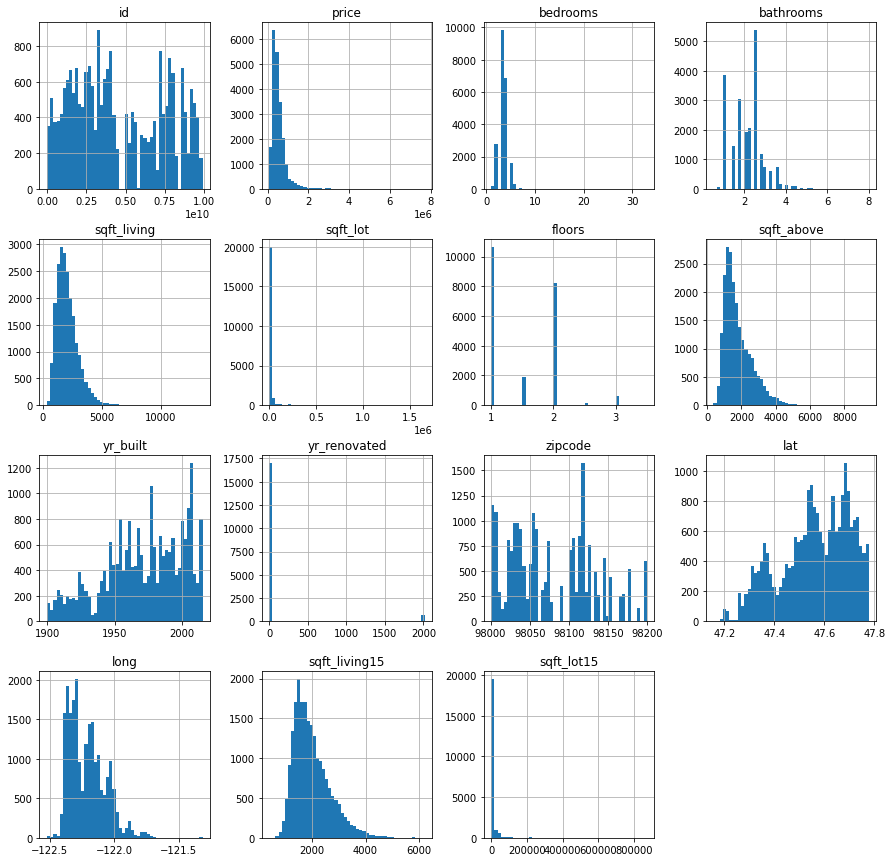

In [137]:
kc_houses.hist(bins=50,figsize  = [15, 15]); 

In [138]:
k_cols

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15'],
      dtype='object')

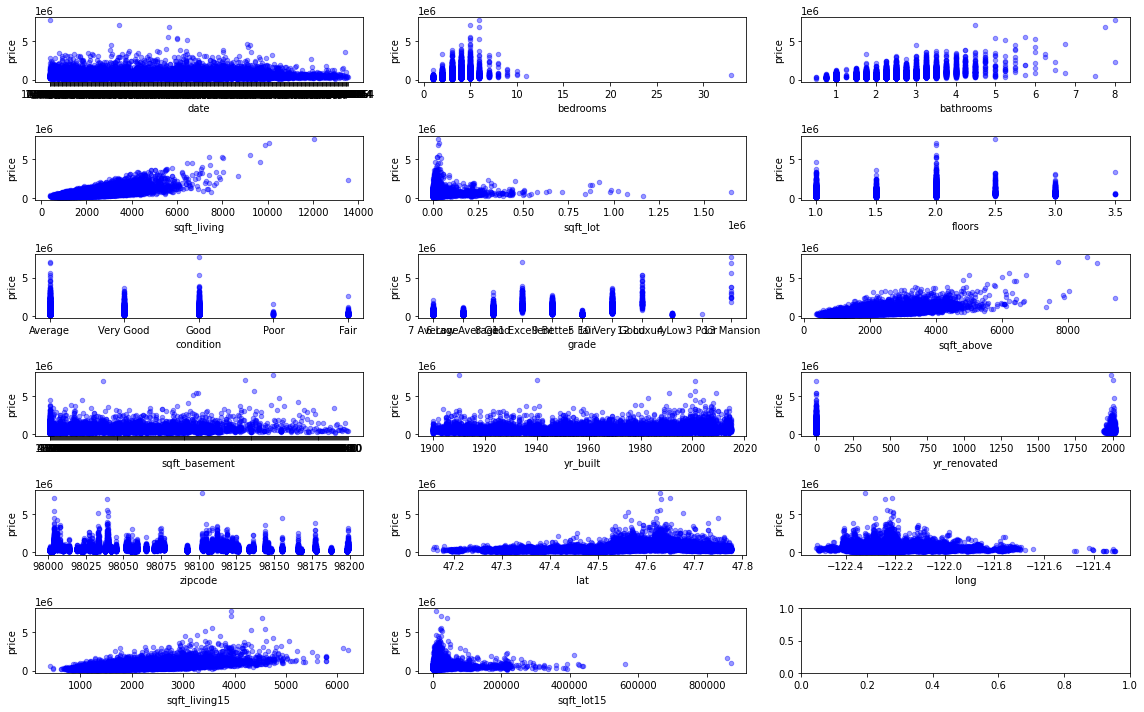

In [139]:
kc_h = kc_houses.drop(columns=['id','waterfront','view','price'])
k_cols = kc_h.columns
fig, axes = plt.subplots(nrows=6, ncols=math.ceil(len(k_cols)/6), figsize=(16,10))
axe = axes.flatten()

for i, xcol in enumerate(k_cols):
    kc_houses.plot(kind='scatter', x=xcol, y='price', ax=axe[i], alpha=0.4, color='b')

plt.tight_layout()

Text(0, 0.5, 'Price ($ MM)')

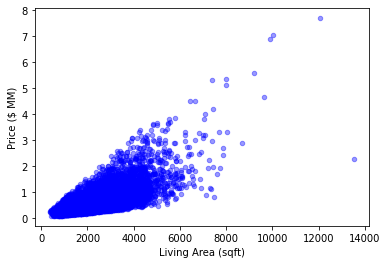

In [140]:
kc_houses2=kc_houses.copy()
kc_houses2['price'] = kc_houses2['price']/1e6
kc_houses2.plot(kind='scatter', x='sqft_living', y='price', alpha=0.4, color='b')
plt.xlabel('Living Area (sqft)')
plt.ylabel('Price ($ MM)')

Text(0, 0.5, 'Price ($ MM)')

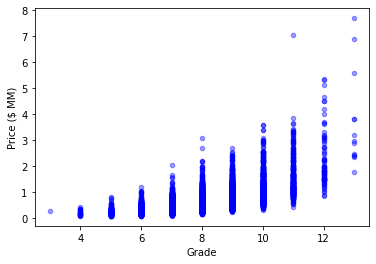

In [141]:
grade_dict = {'7 Average':7, '8 Good':8, '9 Better':9, '6 Low Average':6, '10 Very Good':10,
       '11 Excellent':11, '5 Fair':5, '12 Luxury':12, '4 Low':4, '13 Mansion':13, '3 Poor':3}
kc_houses2['grade2']= kc_houses2['grade'].replace(grade_dict, inplace=True)
kc_houses2.plot(kind='scatter', x='grade', y='price', alpha=0.4, color='b')
plt.xlabel('Grade')
#plt.xticks(rotation = 45)
plt.ylabel('Price ($ MM)')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Price ($MM)')

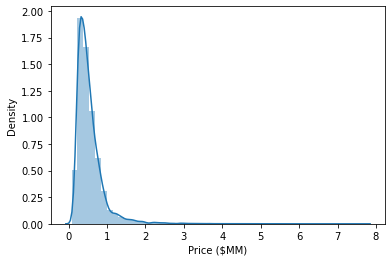

In [142]:
sns.distplot(kc_houses2.price)
plt.xlabel('Price ($MM)')

In [143]:
kc_houses.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

## Fill in the Missing Values

In [144]:
kc_houses.waterfront.value_counts()

NO     19075
YES      146
Name: waterfront, dtype: int64

In [145]:
# NA values in waterfront column being filled with 0.  
kc_houses.waterfront.fillna(0, inplace = True)
kc_houses.waterfront.isna().sum() == 0

True

In [146]:
kc_houses.view.value_counts()

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

In [147]:
# NA values in view column being filled with 0.  
kc_houses.view.fillna(0, inplace = True)
kc_houses.view.isna().sum() == 0

True

In [148]:
kc_houses.yr_renovated.value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

In [149]:
# NA values in yr_renovated column being filled with 0.  
kc_houses.yr_renovated.fillna(0, inplace = True)
kc_houses.yr_renovated.isna().sum() == 0

True

In [150]:
kc_houses.isna().sum().sum()

0

No more missing values!

In [151]:
kc_houses.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,4.580474e+09,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,1788.596842,1970.999676,68.758207,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,2.876736e+09,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,827.759761,29.375234,364.037499,53.513072,0.138552,0.140724,685.230472,27274.441950
min,1.000102e+06,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [152]:
kc_houses.price.mean()

540296.5735055795

## Data Types

In [153]:
kc_houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     21597 non-null  object 
 9   view           21597 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   21597 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [154]:
kc_houses.waterfront.value_counts()

NO     19075
0       2376
YES      146
Name: waterfront, dtype: int64

In [155]:
kc_houses.view.value_counts()

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
0               63
Name: view, dtype: int64

In [156]:
kc_houses.condition.value_counts()

Average      14020
Good          5677
Very Good     1701
Fair           170
Poor            29
Name: condition, dtype: int64

In [157]:
kc_houses.grade.value_counts()

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

The categorical features, waterfront, view, condition and grade are ordinal. They have some meaningful ranking in terms of how they affect the price so I will convert them to integer values, no need for one hot encoding. 

In [158]:
kc_houses['waterfront'] = [1 if x=='YES' else 0 for x in kc_houses['waterfront']]

In [159]:
view_dict = {'NONE':0, 'FAIR':1,'AVERAGE':2, 'GOOD':3, 'EXCELLENT':4}
kc_houses.view.replace(view_dict, inplace=True)

In [160]:
cond_dict = {'Average':5, 'Very Good':4, 'Good':3, 'Fair':2, 'Poor':1}
kc_houses.condition.replace(cond_dict, inplace=True)

In [161]:
kc_houses['sqft_basement'].value_counts().keys()

Index(['0.0', '?', '600.0', '500.0', '700.0', '800.0', '400.0', '1000.0',
       '300.0', '900.0',
       ...
       '1481.0', '2600.0', '1275.0', '2050.0', '4130.0', '2730.0', '2196.0',
       '1852.0', '935.0', '1525.0'],
      dtype='object', length=304)

In [162]:
kc_houses['sqft_basement']=[0 if x=='?' else float(x) for x in kc_houses['sqft_basement']]

In [163]:
grade_dict = {'7 Average':7, '8 Good':8, '9 Better':9, '6 Low Average':6, '10 Very Good':10,
       '11 Excellent':11, '5 Fair':5, '12 Luxury':12, '4 Low':4, '13 Mansion':13, '3 Poor':3}
kc_houses.grade.replace(grade_dict, inplace=True)

In [164]:
kc_houses.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [165]:
# continuous variables
cont_vars = ['sqft_living', 'sqft_lot', 'sqft_living15', 'sqft_lot15', 'yr_built', 'lat', 'long']
# ordinal variables
ord_vars = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']
# categorical variables
cat_vars = ['zipcode']

## Removing Outliers

In [166]:
len(kc_houses[kc_houses.bedrooms>6])

62

In [167]:
kc_houses = kc_houses[kc_houses.bedrooms<=6]

In [168]:
len(kc_houses[kc_houses['sqft_living']>10000])

2

In [169]:
kc_houses = kc_houses[kc_houses['sqft_living']<=10000]

In [170]:
len(kc_houses[kc_houses['sqft_lot']>750000])

11

In [171]:
kc_houses = kc_houses[kc_houses['sqft_lot']<=75000]

In [172]:
len(kc_houses[kc_houses['sqft_lot15']>400000])

0

In [173]:
len(kc_houses[kc_houses.bathrooms>7])

1

In [174]:
kc_houses = kc_houses[kc_houses.bathrooms<=7]

In [175]:
kc_houses.shape

(20932, 21)

## Baseline Model

In [176]:
houses00 = kc_houses.drop(columns=['id','date']).copy()
outcome00 = 'price'
predictors00 = houses00.drop(['price'], axis=1)
pred_sum00 = "+".join(predictors00.columns)
formula00 = outcome00 + "~" + pred_sum00
model00 = ols(formula = formula00, data=houses00).fit()
model00.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     2770.
Date:                Tue, 15 Mar 2022   Prob (F-statistic):               0.00
Time:                        23:04:04   Log-Likelihood:            -2.8451e+05
No. Observations:               20932   AIC:                         5.691e+05
Df Residuals:                   20913   BIC:                         5.692e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.064e+07   2.86e+06      3.713      0.000    5.02e+06    1.62e+07
bedrooms      -3.841e+04   2003.070    -19.176      0.000   -4.23e+04   -3.45e+04
bathrooms      4.298e+04   3222.019     13.340      0.000    3.67e+04    4.93e+04
sqft_living     117.5756     18.357      6.405      0.000      81.595     153.556
sqft_lot         -1.3906      0.219     -6.352      0.000      -1.820      -0.961
floors         2955.4287   3599.977      0.821      0.412   -4100.805       1e+04
waterfront     6.107e+05   1.79e+04     34.164      0.000    5.76e+05    6.46e+05
view           5.307e+04   2114.302     25.102      0.000    4.89e+04    5.72e+04
condition     -1.285e+04   1650.397     -7.784      0.000   -1.61e+04   -9610.999
grade          9.984e+04   2136.114     46.740      0.000    9.57e+04    1.04e+05
sqft_above       59.0949     18.326      3.225      0.001      23.174      95.015
sqft_basement    33.9678     18.163      1.870      0.061      -1.634      69.569
yr_built      -2746.8801     69.136    -39.732      0.000   -2882.391   -2611.369
yr_renovated     18.6158      3.896      4.778      0.000      10.980      26.252
zipcode        -586.1578     32.154    -18.230      0.000    -649.182    -523.133
lat            5.998e+05   1.06e+04     56.776      0.000    5.79e+05     6.2e+05
long          -1.898e+05   1.32e+04    -14.399      0.000   -2.16e+05   -1.64e+05
sqft_living15    26.4713      3.482      7.603      0.000      19.647      33.295
sqft_lot15       -0.2628      0.166     -1.586      0.113      -0.588       0.062
==============================================================================
Omnibus:                    14528.835   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           612745.102
Skew:                           2.825   Prob(JB):                         0.00
Kurtosis:                      28.897   Cond. No.                     2.12e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.12e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Feature Engineering

In [177]:
#Use the "sqft_basement" column to create "has_basement" column
kc_houses['has_basement']=[1 if x>0 else 0 for x in kc_houses['sqft_basement']]
ord_vars.append('has_basement')

In [178]:
# converting data types
kc_houses['date'] = pd.to_datetime(kc_houses['date'])

In [179]:
kc_houses.date.sort_values()

8293    2014-05-02
7316    2014-05-02
11879   2014-05-02
14075   2014-05-02
13095   2014-05-02
           ...    
15797   2015-05-14
7891    2015-05-14
5632    2015-05-15
13040   2015-05-24
16580   2015-05-27
Name: date, Length: 20932, dtype: datetime64[ns]

In [180]:
#Change the "year_renovated" column to "renovated_or_not" to make it more meaningful
kc_houses['renovated_or_not']=[1 if x>0 else 0 for x in kc_houses['yr_renovated']]
ord_vars.append('renovated_or_not')

In [181]:
# calculate the age of the house
kc_houses['age'] = pd.DatetimeIndex(kc_houses['date']).year - kc_houses['yr_built']

In [182]:
kc_houses['sell_month'] = pd.DatetimeIndex(kc_houses['date']).month
newdf = kc_houses.groupby(['sell_month','bedrooms']).mean()['price'].reset_index()
newdf[newdf['bedrooms']==3]

,sell_month,bedrooms,price
2,1,3,457806.587558
8,2,3,457473.100000
14,3,3,469040.788599
20,4,3,484447.308478
26,5,3,461120.078641
32,6,3,479532.761053
38,7,3,465850.072801
44,8,3,461908.232506
50,9,3,451492.634981
56,10,3,457191.791358


In [183]:
# find the sale month
kc_houses['sell_season'] = [1 if ((x>4)&(x<10)) else 0 for x in pd.DatetimeIndex(kc_houses['date']).month]
ord_vars.append('sell_season')

In [184]:
# create some new features that may be useful
#kc_houses['sqft_living_comp'] = kc_houses['sqft_living']/kc_houses['sqft_living15']
#kc_houses['sqft_lot_comp'] = kc_houses['sqft_lot']/kc_houses['sqft_lot15']
#cont_vars.append('sqft_living_comp')
#cont_vars.append('sqft_lot_comp')

<AxesSubplot:xlabel='zipcode', ylabel='price'>

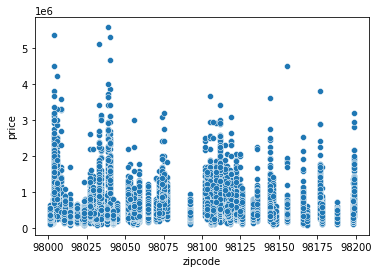

In [185]:
sns.scatterplot(data=kc_houses,x='zipcode',y='price')

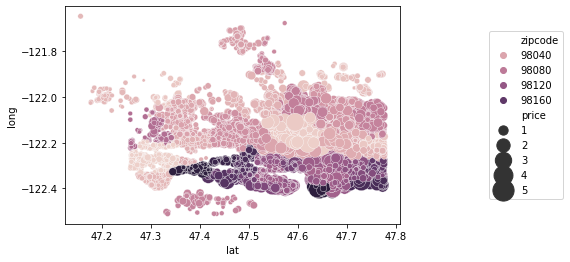

In [186]:
kc_houses2 = kc_houses[kc_houses['long']<-121.6]
g = sns.scatterplot(data=kc_houses2,x="lat", y="long", hue="zipcode", size='price',sizes=(3, 500))
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

## Feature Scaling and Normalization

While normality of the predictors is not a mandatory assumption, having (approximately) normal features may be helpful for the model!

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


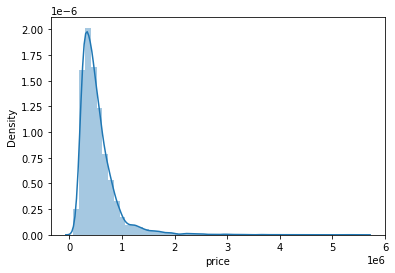

<Figure size 432x288 with 0 Axes>

In [187]:
y = kc_houses.price
mu_original_price = y.mean()
std_original_price = y.std()
sns.distplot(y)
fig = plt.figure()

The distribution of the target feature, price, is certainly right skewed. Log transformation can help reduce skewness, thus reducing the variability of data.

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


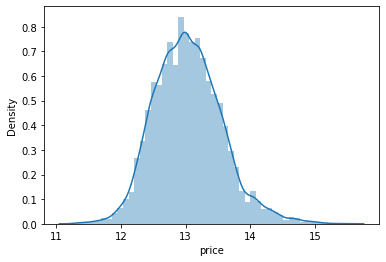

In [188]:
y_trans = np.log1p(y)
mu_logged_price = y.mean()
std_logged_price = y.std()
kc_houses['price'] = y_trans
sns.distplot(y_trans);

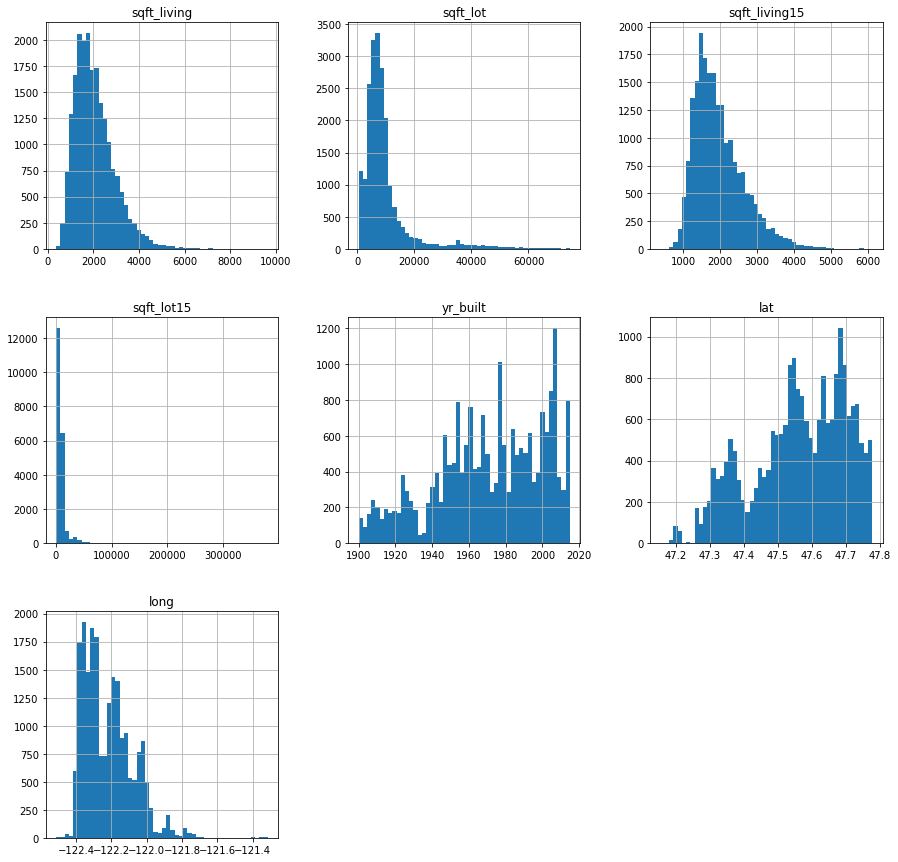

In [189]:
kc_houses[cont_vars].hist(bins=50,figsize  = [15, 15]); 

In [190]:
kc_cont = kc_houses[cont_vars]

# log features
log_names = [f'{column}_log' for column in kc_cont.columns]

kc_log = np.log(kc_cont)
kc_log.columns = log_names

# normalize (subract mean and divide by std)

def normalize(feature):
    return (feature - feature.mean()) / feature.std()

kc_log_norm = kc_log.apply(normalize)

kc_cont_norm = kc_cont.apply(normalize)

<ipython-input-190-1ee96301cccb>:6: RuntimeWarning: invalid value encountered in log
  kc_log = np.log(kc_cont)


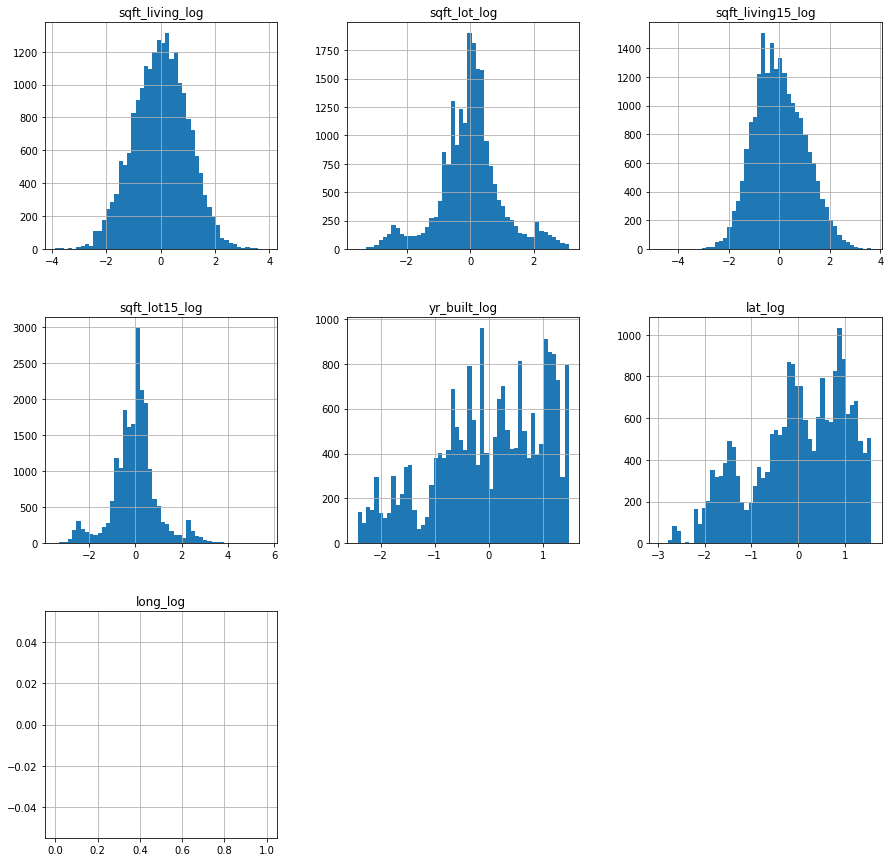

In [191]:
kc_log_norm.hist(bins=50,figsize  = [15, 15]); 

The distributions of the following features became closer to normal:
['sqft_living_log', 'sqft_lot_log', 'sqft_living15_log','sqft_lot15_log']

The distributions of the following features did not become close to normal:
['yr_built','lat','long']

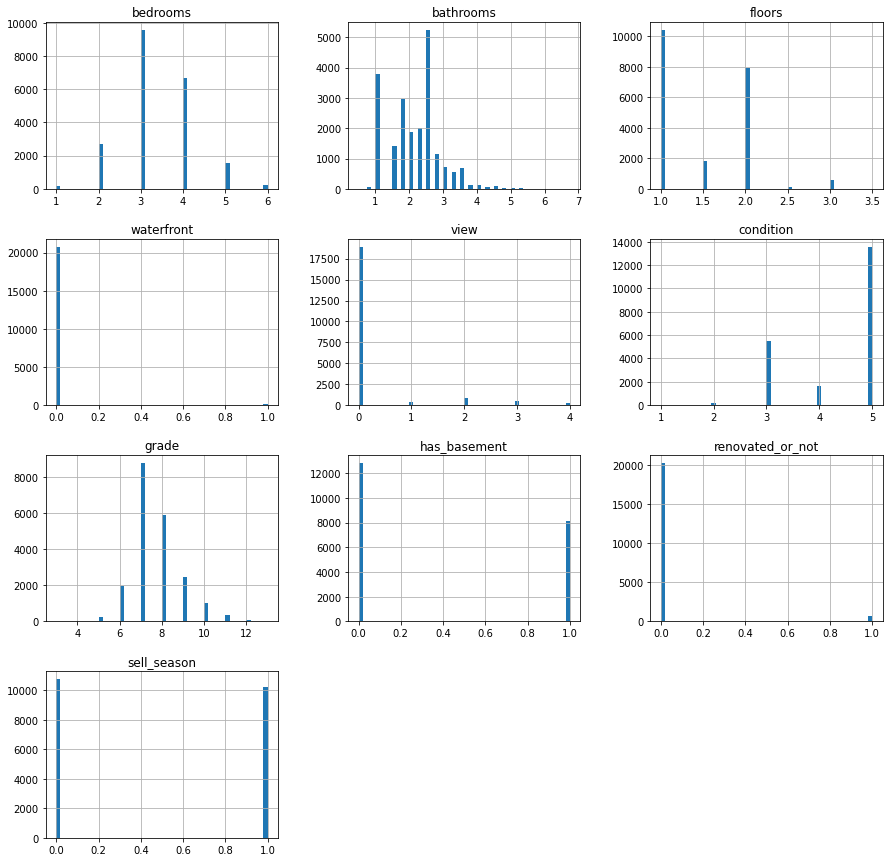

In [192]:
kc_ord = kc_houses[ord_vars]
kc_ord_norm = kc_ord.apply(normalize)
kc_ord.hist(bins=50,figsize  = [15, 15]); 

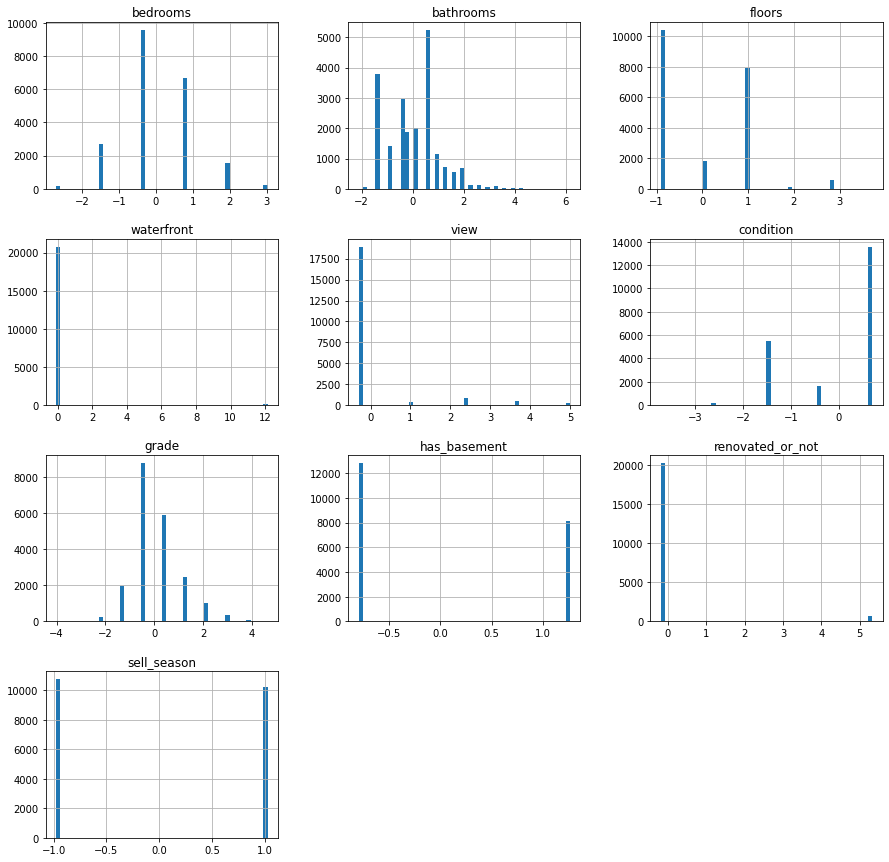

In [193]:
kc_ord_norm.hist(bins=50,figsize  = [15, 15]); 

In [194]:
# Define one-hot encoding function
def one_hot_encode(df, catcols):
    '''Returns df with dummy vars and drops original column'''
    
    # Create DataFrame with above columns
    dfonehot = df[catcols].astype('category')
    
    # Get dummy variables and drop first one to not create dependency
    dfonehot = pd.get_dummies(dfonehot, drop_first = True)
    
    # Recreate DataFrame with one-hot encoded variables
    df = pd.concat([df,dfonehot], axis=1)
    
    # Drop columns where we have done one-hot encoding
    df = df.drop(catcols, axis = 1)
        
    return df

In [195]:
# one hot encode categoricals
kc_ohe = one_hot_encode(kc_houses[cat_vars], cat_vars)

In [196]:
houses0.head()

NameError: name 'houses0' is not defined

## New Model

In [ ]:
houses0 = pd.concat([kc_houses['price'], 
                     kc_log_norm[['sqft_living_log', 'sqft_lot_log', 
                                  'sqft_living15_log','sqft_lot15_log']],
                     kc_cont_norm[['yr_built','lat','long']], kc_ord_norm, kc_ohe
                   ], axis=1)
outcome0 = 'price'
predictors0 = houses0.drop(['price'], axis=1)
pred_sum0 = "+".join(predictors0.columns)
formula0 = outcome0 + "~" + pred_sum0
model0 = ols(formula = formula0, data=houses0).fit()
model0.summary()

## Linearity

Multiple linear regression assumes that there is a linear relationship between each predictor variable and the response variable.

In [ ]:
kc_cont2 = pd.concat([kc_log_norm[['sqft_living_log', 'sqft_lot_log', 
                                  'sqft_living15_log','sqft_lot15_log']],
                     kc_cont_norm[['yr_built','lat','long']],
                    kc_houses['price']],axis=1)
kc_cont3 = kc_cont2.drop(columns=['price'])
cont_cols = kc_cont3.columns
fig, axes = plt.subplots(nrows=2, ncols=math.ceil(len(cont_cols)/2), figsize=(16,6))
axe = axes.flatten()

for i, xcol in enumerate(cont_cols):
    kc_cont2.plot(kind='scatter', x=xcol, y='price', ax=axe[i], alpha=0.4, color='b')

plt.tight_layout()

In [ ]:
#kc_cont_norm['yr_built2'] = [-1 if x<-1 else x for x in kc_cont_norm['yr_built']]

In [ ]:
kc_ord2 = pd.concat([kc_ord_norm, kc_houses['price']],axis=1)
ord_cols = kc_ord_norm.columns
fig, axes = plt.subplots(nrows=2, ncols=math.ceil(len(ord_cols)/2), figsize=(16,6))
axe = axes.flatten()

for i, xcol in enumerate(ord_cols):
    kc_ord2.plot(kind='scatter', x=xcol, y='price', ax=axe[i], alpha=0.4, color='b')

plt.tight_layout()

In [ ]:
kc_ord_norm['floors'].unique()

In [ ]:
kc_ord_norm['floors2'] = [1.86289013 if x>1.86289013 else x for x in kc_ord_norm['floors']]

In [ ]:
kc_ohe2 = pd.concat([kc_ohe, kc_houses['price']],axis=1)
cat_cols = kc_ohe.columns
fig, axes = plt.subplots(nrows=7, ncols=math.ceil(len(cat_cols)/7), figsize=(15,10))
axe = axes.flatten()

for i, xcol in enumerate(cat_cols):
    kc_ohe2.plot(kind='scatter', x=xcol, y='price', ax=axe[i], alpha=0.4, color='b')

plt.tight_layout()

The following columns have linear relationship with the target variable:

sqft_living_log, sqft_living15_log, bedrooms, bathrooms, grade

The following also seems to affect the price:

floors2, waterfront, has_basement, renovated_or_not

In [ ]:
houses = pd.concat([kc_houses['price'], kc_log_norm[['sqft_living_log', 
                                                     'sqft_living15_log']],
                    kc_ord_norm[['bedrooms', 'bathrooms', 'grade','floors2', 
                            'waterfront', 'has_basement', 'renovated_or_not']]
                   ], axis=1)

## Correlation and Multicollinearity

In [ ]:
#heatmap_data = pd.concat([kc_houses['price'], preprocessed1.drop(columns='price'), kc_ord], axis=1)
heatmap_data = houses
corr = heatmap_data.corr()

fig, ax = plt.subplots(figsize=(10, 15))

sns.heatmap(
    data=corr,
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    ax=ax,
    annot=True,
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

In [ ]:
# save absolute value of correlation matrix as a data frame
# converts all values to absolute value
# stacks the row:column pairs into a multindex
# reset the index to set the multindex to seperate columns
# sort values. 0 is the column automatically generated by the stacking

df=heatmap_data.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
df['pairs'] = list(zip(df.level_0, df.level_1))

# set index to pairs
df.set_index(['pairs'], inplace = True)

#d rop level columns
df.drop(columns=['level_1', 'level_0'], inplace = True)

# rename correlation column as cc rather than 0
df.columns = ['cc']

# drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
# for the sake of exercise, kept it in.
df.drop_duplicates(inplace=True)
df[(df.cc>.6) & (df.cc <1)]

The above pairs of features have strong multicollinearity. One solution would be combining variables.

In [ ]:
heatmap_data.corr()['price'].map(abs).sort_values(ascending=False)

## Model with Selected Features

In [ ]:
houses1 = houses.copy()
outcome1 = 'price'
predictors1 = houses1.drop(['price'], axis=1)
pred_sum1 = "+".join(predictors1.columns)
formula1 = outcome1 + "~" + pred_sum1
model1 = ols(formula = formula1, data=houses1).fit()
model1.summary()

## Model with Reduced Multicollinearity

In [ ]:
houses2 = houses.copy()
houses2.drop(columns= ['bedrooms','bathrooms','sqft_living15_log'],inplace = True)

outcome2 = 'price'
predictors2 = houses2.drop(['price'], axis=1)
pred_sum2 = "+".join(predictors2.columns)
formula2 = outcome2 + "~" + pred_sum2
model2 = ols(formula = formula2, data=houses2).fit()
model2.summary()

## Model with Even More Reduced Multicollinearity

In [ ]:
houses3 = houses.copy()
#houses2['gradeandbedroomsandbathroomsandlivingand15'] = houses2['grade']*houses2['bedrooms']*houses2['bathrooms']*houses2['sqft_living_log']*houses2['sqft_living15_log']
#houses2.drop(columns= ['grade','bedrooms','bathrooms','sqft_living_log','sqft_living15_log'],inplace = True)
houses3['livingand15'] = houses3['sqft_living_log']+houses3['sqft_living15_log']
houses3.drop(columns= ['sqft_living_log','sqft_living15_log'],inplace = True)

outcome3 = 'price'
predictors3 = houses3.drop(['price'], axis=1)
pred_sum3 = "+".join(predictors3.columns)
formula3 = outcome3 + "~" + pred_sum3
model3 = ols(formula = formula3, data=houses3).fit()
model3.summary()

## Model with New Created Feature

In [ ]:
kc_houses['renovated_age'] = kc_houses['age'] - 20 * kc_houses['renovated_or_not']
kc_houses['renovated_age'] = kc_houses[['renovated_age']].apply(normalize)
houses4 = houses.copy()
houses4 = pd.concat([houses3,kc_houses[['renovated_age']]], axis=1)
houses4.drop(columns= ['renovated_or_not'],inplace = True)

outcome4 = 'price'
predictors4 = houses4.drop(['price'], axis=1)
pred_sum4 = "+".join(predictors4.columns)
formula4 = outcome3 + "~" + pred_sum4
model4 = ols(formula = formula4, data=houses4).fit()
model4.summary()

# Investigating Linearity

In [ ]:
#pip install matplotlib --upgrade

In [ ]:
models = [model0, model1, model2, model3, model4]
housess=[houses0, houses1, houses2, houses3, houses4]
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,5),sharex=True, sharey=True)
for i in range(1,6):
    model = models[i-1] 
    thishouse = housess[i-1]    
    X = thishouse.drop('price', axis=1)
    y = thishouse['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=42)    
    colnames = houses.columns
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    print('Train score for Model '+str(i-1)+': '+ str(lr.score(X_train, y_train)))
    print('Test score for Model '+str(i-1)+': '+ str(lr.score(X_test, y_test)))
    y_predict = lr.predict(X_test)
    axes[i-1].plot(y_test, y_test, linestyle="--", color="orange", label="Perfect Fit")
    axes[i-1].scatter(y_test, y_predict, alpha=0.5)
    axes[i-1].set_title('Model '+str(i-1))
fig.supxlabel('Actual Price')
fig.supylabel('Predicted Price')
fig.tight_layout()
plt.show()

In general it looks like we have a linear relationship (not violating the linearity assumption).

The r-squared value, ~60%, indicates that the model can account for about ~60% of the variability of price around its mean. The null hypothesis for multiple regression is that there is no relationship between the chosen explanatory variables and the response variable. All of the p-values round to 0 (except for the "renovated_or_not" feature in model1, which means we can reject the null hypothesis. Now we can confirm that the model satisfies the assumptions of normality and homoscedasticity.


# Investigating Normality

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,5),sharex=True, sharey=True)
for i in range(1,6):
    model = models[i-1] 
    thishouse = housess[i-1]    
    X = thishouse.drop('price', axis=1)
    y = thishouse['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=42)
    preds = model.predict(X_test)
    residuals = (y_test - preds)
    sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True, ax =axes[i-1]);
    axes[i-1].set_title('Model '+str(i-1))
fig.supxlabel('Actual Price')
fig.supylabel('Predicted Price')
fig.tight_layout()
plt.show();

There are some outliers but it is not too bad. We can probably say that we are not violating the normality assumption except for the Model 0.

# Investigating Multicollinearity (Independence Assumption)

In [ ]:
#fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5),sharex=True, sharey=True)
for i in range(1,6):
    print('Model '+str(i-1))
    thishouse = housess[i-1]    
    X = thishouse.drop('price', axis=1)
    y = thishouse['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=42)
    colnames = thishouse.columns
    vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    vif_df = pd.DataFrame(vif, index=X_train.columns , columns=["Variance Inflation Factor"])
    vif_df = vif_df[vif_df['Variance Inflation Factor']>5]
    if vif_df.shape[0] == 0:
        print('No VIF values greater than 0')
    else:
        print('VIF values that are greater than 5:')
        print(vif_df)
    print(' ')

Ideally, VIF should be less than 5.

# Investigating Homoscedasticity

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,5),sharex=True, sharey=True)
for i in range(1,6):
    model = models[i-1] 
    thishouse = housess[i-1]    
    X = thishouse.drop('price', axis=1)
    y = thishouse['price']
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=42)
    preds = model.predict(X_test)
    residuals = (y_test - preds)
    axes[i-1].scatter(preds, residuals, alpha=0.5)
    axes[i-1].plot(preds, [0 for i in range(len(X_test))])
    axes[i-1].set_title('Model '+str(i-1))
fig.supxlabel('Predicted Value')
fig.supylabel('Actual - Predicted Value')
fig.tight_layout()
plt.show()

It is not a funnel shape, we are not violating homoscedasticity.

# CONCLUSION

I have concluded that Model 2 is the most suitable model for this analysis.
Reasons:
1. Satisfies linearity assumption of linear regression. 
2. Explains ~56% of the variability in the data.
3. Does not high multicollinearity between dependent variables (VIF<5)
4. Model coefficients are meaningful. (In contradiction, for model 4, the price seems to increase with the increasing age of the house, which is not reasonable, or for model 1 and 3, the price seems to decrease with increasing number of bedrooms, which is again not reasonable.

In [ ]:
model2.summary()

# Interpreting the Coefficients

* Most Important Feature is the Grade of the House
   Increasing the grade of house 1 unit, increases the log of price by 0.25. It has the effect of multiplying by 1.28. So, if a house is worth 100k, it will be worth 128k. This seems to be most effective feature.

* Second Most Important Feature is the Living area
    Increasing the living area by 1 unit will increase the price by 0.1417, which has the effect of multiplying by 1.15. So, if a house is worth 100k, it will be worth 115k.  This seems to be second most effective feature.
    
* With the results of the model, I would highly recommend renovating the house if it helps increase the grade of the house or increasing the living area.

In [ ]:
model = model2
thishouse = houses2   
X = thishouse.drop('price', axis=1)
y = thishouse['price']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        random_state=42)    
colnames = thishouse.columns
lr = LinearRegression()
lr.fit(X_train, y_train)
print('Train score for Model : '+ str(lr.score(X_train, y_train)))
print('Test score for Model : '+ str(lr.score(X_test, y_test)))
y_predict = lr.predict(X_test)
plt.plot(y_test, y_test, linestyle="--", color="orange", label="Perfect Fit")
plt.scatter(y_test, y_predict, alpha=0.5)
plt.title('Model 2')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
fig.tight_layout()
plt.show()

In [ ]:
houses2.columns